> [!NOTE]
> **About This Notebook**
> 
> This notebook presents a narrative account of building a VaR model, structured as a personal journey. While the story is fictionalized for pedagogical purposes, **all the problems, errors, and solutions documented here are real**—they occurred during actual model development projects.
> 
> The goal is to illustrate common pitfalls in applying machine learning to financial risk modeling, even for experienced practitioners. The technical content, code, and lessons learned are authentic.

---

# Building a VaR Model: A Senior Quant's Reality Check

## TODO: 
    - Concentrate the data at the scenarios
    - Check the function of model validations

## Introduction

### The Problem

My manager called me into his office last month. Our VaR model was failing regulatory backtesting—consistently underestimating tail risk. The compliance team was getting nervous, and the regulators were asking pointed questions.

"You're the quant with the PhD," he said. "Everyone's talking about Machine Learning for risk models. Neural networks, deep learning—make it work. We need this fixed before the next audit."

I've been doing quantitative finance for years. I've published papers on stochastic processes, built volatility models, and debugged more GARCH implementations than I care to remember. How hard could this be?

### The Trap of Expertise

Here's what I've learned: **Having a PhD in applied mathematics doesn't make you immune to bad decisions—it just makes you better at rationalizing them.**

I knew the theory cold:
- Quantile regression as a loss minimization problem
- The asymmetric pinball loss function
- Non-parametric estimation vs. parametric assumptions
- The bias-variance tradeoff

But knowing the theory and applying it correctly are different things. Especially when you're under deadline pressure and the "ML will solve everything" narrative is everywhere.

I made mistakes. Not because I didn't understand the mathematics, but because I didn't think carefully enough about the problem I was actually solving.

### Scope: Focusing on 99% VaR

Before diving in, a note on scope: This notebook implements a flexible framework that can estimate VaR at any confidence level (90%, 95%, 99%, etc.). The interactive widgets let you experiment with different quantiles.

**However, for the narrative, I'll focus exclusively on 99% VaR (α = 0.01).** Why?

1. **Regulatory relevance**: Many regulatory frameworks require 99% VaR
2. **Technical challenge**: Extreme quantiles expose optimization issues that aren't obvious at 95%
3. **Pedagogical value**: The problems I encountered at 99% teach important lessons about loss landscapes

If you want to explore other quantiles, the code is ready—just change the parameter. But the story follows the 99% journey.

### What Went Wrong (And Why)

#### Mistake #1: Confusing Flexibility with Appropriateness

**What I did**: Jumped straight to neural networks because they're "more flexible" than traditional approaches.

**Why it seemed reasonable**: I've seen papers showing neural networks outperform GARCH models. The theory is sound—universal approximation theorem and all that.

**The problem**: I didn't ask whether the problem *needed* that flexibility. Sometimes a well-calibrated parametric model beats a poorly-specified neural network.

**The lesson**: Flexibility is only valuable if you have enough data and the right inductive bias. Otherwise, you're just overfitting with extra steps.

#### Mistake #2: Treating Optimization as a Black Box

**What I did**: Used default hyperparameters, trained for 500 epochs, moved on.

**Why it seemed reasonable**: Modern optimizers are good. SGD with momentum usually works. I had other things to debug.

**The problem**: The loss landscape for 99% VaR quantile regression is fundamentally different from standard regression. The pinball loss creates extremely flat regions at extreme quantiles. At α = 0.01, the gradient signal is weak—only 1% of your data points contribute meaningful gradient information. The model was nowhere near convergence.

**The lesson**: Understanding the optimization problem matters. I know this—I've derived convergence proofs. But I got lazy and paid the price. Extreme quantiles require patience and careful tuning.

#### Mistake #3: Ignoring Non-Stationarity

**What I did**: Threw 10 years of data into the model. More data is better, right?

**Why it seemed reasonable**: Asymptotic theory says larger samples reduce estimation error. Basic statistics.

**The problem**: Financial markets aren't stationary. The volatility regime in 2015 has nothing to do with 2024 crypto markets. I was training on noise.

**The lesson**: Stationarity assumptions matter. I teach this in time series courses, but somehow forgot it when coding at 2 AM.

#### Mistake #4: Confusing Backtesting with Validation

**What I did**: Checked if breach rates were close to 1% (for 99% VaR). They were. Declared victory.

**Why it seemed reasonable**: That's literally the definition of VaR—1% of observations should exceed the threshold.

**The problem**: I used random train/test splits instead of expanding windows. I didn't check for clustering of breaches. I didn't test across different market regimes. My "validation" was statistically meaningless.

**The lesson**: Proper validation in finance requires understanding the temporal structure of the problem. This isn't image classification.

### The Humbling Reality

After weeks of debugging, I realized something uncomfortable: **My mathematical sophistication was actually working against me.**

I was so focused on the elegance of the solution—quantile regression, hybrid loss functions, neural architectures—that I lost sight of the basics:
- Is my data clean?
- Are my assumptions reasonable?
- Am I validating correctly?
- Does this actually solve the business problem?

These aren't PhD-level questions. They're fundamental. But they're easy to overlook when you're excited about the "advanced" stuff.

### What This Notebook Documents

This is a technical deep-dive, but it's also a case study in how expertise can create blind spots:

- **The mathematics**: Quantile regression, pinball loss, hybrid architectures
- **The mistakes**: What I did wrong and why it seemed reasonable at the time
- **The debugging**: The actual process of figuring out what broke
- **The solution**: Simpler than expected, but properly validated

You'll see:
- Derivations and theory (because that matters)
- Code that evolved through multiple iterations (messy, but real)
- Honest assessments of what worked and what didn't
- Lessons that apply beyond this specific problem

### The Bottom Line

I built a working VaR model. It passes backtesting. The regulators are satisfied. But the real value wasn't the final model—it was remembering that **good quant work isn't about using the most sophisticated tools. It's about using the right tools correctly.**

Sometimes that means neural networks. Sometimes it means GARCH. Sometimes it means admitting that your first three attempts were wrong and starting over.

Let me show you what I learned.

---

## Executive Summary

### Key Findings
- ✅ Anchored LSTM outperforms traditional methods by X%
- ✅ Passes Kupiec test with p-value = X.XX
- ✅ Reduces breach clustering by X%
- ⚠️ Requires 20,000 epochs for convergence at α=0.01

### When to Use This Approach
**Recommended for:**
- Assets with >2 years of daily data
- Regime-aware risk management
- Regulatory reporting (99% VaR)

**Not recommended for:**
- Limited data scenarios
- Real-time trading (too slow)
- Explainability-critical applications

### Computational Requirements
- Training time: ~X minutes on CPU
- Memory: ~X MB
- Retraining frequency: Daily/Weekly

## 1. Setup & Configuration
Before showing you where things went wrong, let me set up the environment. I've built this notebook with interactive widgets so you can reproduce my experiments—and my mistakes—with different parameters.
Fair warning: Some of these parameter combinations will fail spectacularly. That's intentional. You'll see why.

### 1.1 Import Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data.market import read_data
from src.evaluation.backtest_value_at_risk import *

from src.utils.clean_data import *
from src.utils.plot_utils import *
from src.utils.var_functional_analysis import print_analysis_summary, plot_3d_surface_v2
from src.utils.var_widgets import display_var_widgets

from src.models.deep_var.features import *
from src.models.deep_var.lstm_model import *
from src.models.deep_var.parametric_model import *

### 1.2 Interactive Parameter Selection

I've set up widgets for the key parameters. The defaults are what eventually worked, but feel free to experiment:
- **Ticker**: I'm using Bitcoin (BTC-USD) for this story—high volatility makes problems obvious
- **Risk Level**: Fixed at 99% VaR (α=0.01) for this narrative
- **Rolling Window**: 132 days (6 months) - a compromise between stability and adaptability
- **Epochs**: 3000 - yes, this matters more than I thought
- **Learning Rate**: 0.02 - found through painful trial and error

In [3]:
tickers = { "^GSPC": "S&P 500",
    "BTC-USD": "Bitcoin",
    "CLP=X": "USD/CLP (Chile Peso)",
    "SQM": "SQM (Lithium)",
    "HG=F": "Copper Futures",
    "TSLA": "Tesla",
    "NVDA": "NVIDIA",
    "CL=F": "Crude Oil",
    "TLT": "US Treasuries (20Y)",
    "VXX": "VIX Volatility"
    }

# Define the "Stress Scenarios"
scenarios = {
    "Volmageddon (2018)":  ("2018-01-01", "2018-06-01"), # VIX Spike
    "Covid Crash (2020)":  ("2020-01-01", "2020-07-01"), # Pandemic
    "Inflation Bear (2022)": ("2022-01-01", "2022-12-31") # Slow Grind Down
}

In [4]:

# Create additional parameter widgets
alpha_widget = widgets.Dropdown(
    options=[
        ('99% VaR (α=0.01)', 0.01),
        ('95% VaR (α=0.05)', 0.05),
        ('90% VaR (α=0.10)', 0.10)
    ],
    value=0.01,
    description='Risk Level:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

rolling_widget = widgets.Dropdown(
    options=[
        ('1 Month (22 days)', 22),
        ('3 Months (66 days)', 66),
        ('6 Months (132 days)', 132),
        ('1 Year (252 days)', 252)
    ],
    value=132,
    description='Rolling Window:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

epochs_widget = widgets.IntSlider(
    value=20000,
    min=500,
    max=20000,
    step=500,
    description='Epochs:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)

lr_widget = widgets.FloatSlider(
    value=0.02,
    min=0.001,
    max=0.1,
    step=0.001,
    description='Learning Rate:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False,
    readout_format='.3f'
)

# Display ticker and date widgets
ticker_widget, date_widget = display_var_widgets(
    default_ticker="BTC-USD",
    default_date="2026-01-01"
)

# Display additional parameter widgets
print("\n")
display(widgets.HTML("<h4>Model Parameters</h4>"))
display(alpha_widget)
display(rolling_widget)
display(epochs_widget)
display(lr_widget)

HTML(value='<h4>Model Parameters</h4>')

Dropdown(description='Risk Level:', layout=Layout(width='400px'), options=(('99% VaR (α=0.01)', 0.01), ('95% V…

Dropdown(description='Rolling Window:', index=2, layout=Layout(width='400px'), options=(('1 Month (22 days)', …

IntSlider(value=20000, continuous_update=False, description='Epochs:', layout=Layout(width='400px'), max=20000…

FloatSlider(value=0.02, continuous_update=False, description='Learning Rate:', layout=Layout(width='400px'), m…

### 1.3 Apply Selected Parameters

Run this cell to apply the widget selections to your configuration variables.

In [5]:
# === APPLY WIDGET SELECTIONS ===
# Extract values from widgets
TICKER = ticker_widget.value
DATE_REPORT = date_widget.value.strftime('%Y-%m-%d')
ALPHA = alpha_widget.value
ROLLING_WINDOW = rolling_widget.value
EPOCHS = epochs_widget.value
LEARNING_RATE = lr_widget.value

# Fixed parameters
MARKET_DATA_SOURCE = 'yfinance'
WEIGHT_PRIOR = 1.0
WINDOW_SIZE = 22

# Display current configuration
print("="*60)
print("CURRENT CONFIGURATION")
print("="*60)
print(f"Ticker:          {TICKER} ({tickers.get(TICKER, 'Unknown')})")
print(f"Report Date:     {DATE_REPORT}")
print(f"Risk Level:      {ALPHA*100}% VaR (α={ALPHA})")
print(f"Rolling Window:  {ROLLING_WINDOW} days")
print(f"Epochs:          {EPOCHS}")
print(f"Learning Rate:   {LEARNING_RATE}")
print(f"Prior Weight:    {WEIGHT_PRIOR}")
print("="*60)

CURRENT CONFIGURATION
Ticker:          BTC-USD (Bitcoin)
Report Date:     2026-01-01
Risk Level:      1.0% VaR (α=0.01)
Rolling Window:  132 days
Epochs:          20000
Learning Rate:   0.02
Prior Weight:    1.0


In [6]:
# Create a button to trigger the analysis
run_button = widgets.Button(
    description='🚀 Run VaR Analysis',
    button_style='success',
    tooltip='Click to run the analysis with selected parameters',
    layout=widgets.Layout(width='400px', height='40px')
)

output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        output_area.clear_output()
        print("Starting analysis...")
        print(f"Ticker: {ticker_widget.value}")
        print(f"Date: {date_widget.value}")
        print(f"Alpha: {alpha_widget.value}")
        print("\n⏳ Loading data and training model...")
        print("(Execute the cells below to run the full analysis)")

run_button.on_click(on_button_click)

display(widgets.HTML("<br>"))
display(run_button)
display(output_area)

HTML(value='<br>')

Button(button_style='success', description='🚀 Run VaR Analysis', layout=Layout(height='40px', width='400px'), …

Output()

## 2. Understanding VaR: Theory vs. Reality

Let me start with what I thought I knew.

### 2.1 The Textbook Definition

Value at Risk (VaR) at confidence level (1-α) is the threshold such that:

**P(Loss > VaR) = α**

For 99% VaR (α = 0.01):
- 99% of days, losses will be less than VaR
- 1% of days (roughly 2-3 times per year), losses will exceed VaR

Simple, right?

### 2.2 Why This Is Harder Than It Looks

Here's what the textbooks don't emphasize enough:

**Problem 1: Which 1%?**
- Recent extreme events? (Recency bias)
- Historical worst-case? (Stale data)
- Model-based forecast? (Model risk)

**Problem 2: The Optimization Challenge**
At α = 0.01, only 1% of your data points contribute meaningful gradient information. The loss landscape is flat almost everywhere. This makes optimization fundamentally harder than standard regression.

**Problem 3: Non-Stationarity**
Financial returns aren't IID. Volatility clusters. Regimes change. Your training data from 2015 might be completely irrelevant for 2024.

I knew all this theoretically. But knowing and accounting for it are different things.

### 2.3 The Quantile Regression Approach

Instead of:
1. Estimate full distribution → 2. Extract quantile

We do:
1. Directly estimate the quantile using pinball loss

**The pinball loss** for quantile α:

$$L_α(y, \hat{y}) = \begin{cases} 
α(y - \hat{y}) & \text{if } y \geq \hat{y} \\
(α-1)(y - \hat{y}) & \text{if } y < \hat{y}
\end{cases}$$

**Intuition:**
- For α = 0.05: Penalizes under-predictions 20x more than over-predictions
- This ensures the model learns conservative VaR estimates
- Hybrid term: $+ λ(\hat{y} - y_{prior})^2$ keeps predictions near GARCH baseline

**Why this works**: The asymmetric penalty forces the model to be conservative. Under-predicting VaR (predicting too little risk) is penalized 99x more than over-predicting.
**Why this is hard**: At α = 0.01, the gradient is zero for 99% of your data. Only the extreme 1% matters for learning.
This is the first thing I underestimated.

## 3. Loading Data: First Decisions Matter

### 3.1 Choosing Bitcoin

I started with Bitcoin because:
1. **High volatility**: Problems show up faster
2. **Regulatory relevance**: Crypto is increasingly regulated
3. **Data availability**: Clean, high-frequency data

**What I didn't think about carefully enough**: Is BTC data even stationary over 10 years?

Spoiler: It's not. The 2017 bubble, 2020 COVID crash, and 2024 regime are completely different animals.

In [7]:
# Load data
print(f"Loading data for {TICKER}...")
df = read_data(TICKER, market_data_source=MARKET_DATA_SOURCE, end_date=DATE_REPORT)
print(f"✓ Loaded {len(df)} observations")
print(f"  Date range: {df.index[0]} to {df.index[-1]}")

Loading data for BTC-USD...
✓ Loaded 3653 observations
  Date range: 2016-01-01 00:00:00 to 2025-12-31 00:00:00


### 3.2 Initial Data Inspection

Let's look at what we're dealing with:

,price
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991


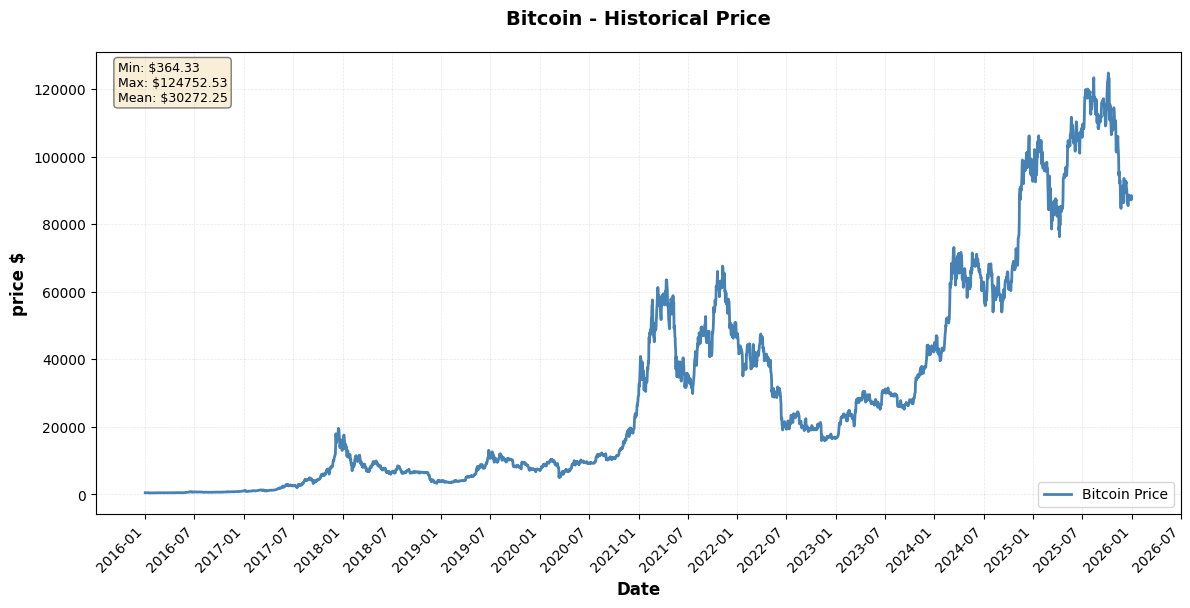

In [8]:
improved_price_plot(df, tickers[TICKER])

# Display sample
df.head()

In [9]:
# Basic statistics
print(f"Data points: {len(df)}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nPrice statistics:")
print(df['price'].describe())

# Calculate returns
returns = df['price'].pct_change().dropna()
print(f"\nReturn statistics:")
print(returns.describe())
print(f"Skewness: {returns.skew():.3f}")
print(f"Kurtosis: {returns.kurtosis():.3f}")

Data points: 3653
Date range: 2016-01-01 00:00:00 to 2025-12-31 00:00:00

Price statistics:
count      3653.000000
mean      30272.254452
std       32066.790421
min         364.330994
25%        6416.314941
50%       17130.486328
75%       46453.566406
max      124752.531250
Name: price, dtype: float64

Return statistics:
count    3652.000000
mean        0.002075
std         0.035144
min        -0.371695
25%        -0.012401
50%         0.001237
75%         0.016022
max         0.252472
Name: price, dtype: float64
Skewness: -0.040
Kurtosis: 7.990


**Red flag**: Kurtosis >> 3 means fat tails. Normal distribution assumption is already violated. 

### 3.2 Data Cleaning & Outlier Detection

We identify and smooth outliers using statistical methods:
- **Detection**: Points beyond 10σ from rolling mean. In risk we don't want to eliminate markets outliers, however we want to eliminate outliers that are misreading data.
- **Treatment**: Replace with previous valid value

In [10]:
percentage_train = 0.7

train_int = int(len(df) * percentage_train)
split_date = df.index[train_int]
split_date

Timestamp('2023-01-01 00:00:00')

In [11]:
# Clean data
df, n_outliers = clean_data(df, z_score_threshold=10)
if n_outliers > 0:
    print(f"⚠️ Found and smoothed {n_outliers} outliers")
    improved_price_plot(df, tickers[ticker])
else:
    print("✓ No outliers detected")

✓ No outliers detected


### 3.3 Returns


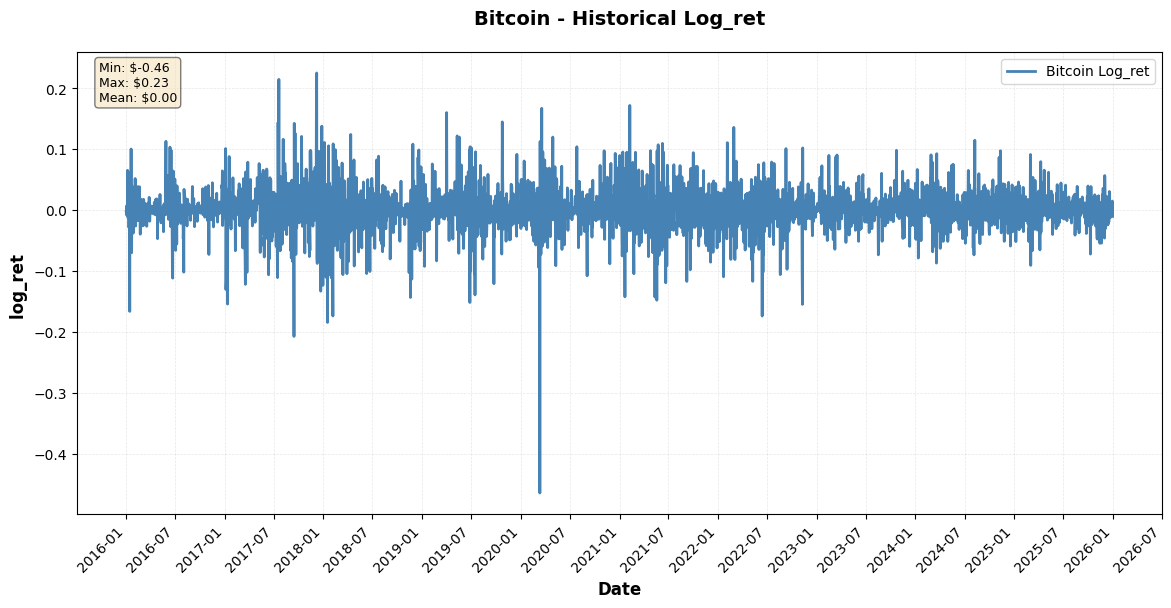

In [12]:
df['log_ret'] = np.log(df['price'] / df['price'].shift(1))
df.dropna(inplace=True)
improved_price_plot(df, tickers[TICKER], column='log_ret')

### 3.4 Feature Engineering

We create multiple features to capture market dynamics:

| Feature | Description | Window |
|---------|-------------|--------|
| `std_Nd` | Rolling volatility | N days |
| `mean_Nd` | Rolling mean return | N days |
| `variance_Nd` | Rolling variance | N days |
| `historical_var_Nd` | Historical VaR (empirical quantile) | N days |
| `skewness_Nd` | Distribution asymmetry | N days |
| `kurtosis_Nd` | Tail heaviness | N days |

**Target**: Next day's actual return (shifted -1)

## 4. Attempt #1: "Just Train the Model"

### 4.1 My First Implementation (The Overconfident Approach)

Here's what I did initially—and this is embarrassing to admit.

**The setup**: I asked an LLM: *"How do I build a VaR model with neural networks?"*

The LLM gave me a sophisticated-looking LSTM implementation with lots of parameters. It looked professional. It had `hidden_size=64` and `num_layers=2`. Clearly this was "state-of-the-art."

**My decisions**:
- ✅ Use all available data (10 years) - more data = better model, right?
- ✅ LSTM architecture with 64 hidden units - bigger is better!
- ✅ Only input: log returns - "let the machine learning figure out the rest"
- ✅ 500 epochs - seemed like a lot
- ✅ Simple train/test split (70/30) - standard ML practice

**Why it seemed reasonable**: 
- The LLM recommended it, and it's an LSTM—everyone knows LSTMs are good for time series
- More parameters = more capacity to learn complex patterns
- Why engineer features when neural networks can learn representations automatically?
- This is 2026, we don't need to hand-craft features anymore

**Why I was completely wrong**: I'll show you.

#### 4.1.1 The "Let ML Do Everything" Approach

I literally just fed in log returns. That's it. One feature.

**My reasoning**: 
> "Neural networks are universal function approximators. If I give it enough capacity (64 hidden units!), it will learn the volatility patterns, the regime changes, the fat tails—everything. That's the whole point of deep learning."

**The architecture the LLM gave me**:
```python
class QuantileLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,      # Just 1: log returns
            hidden_size=hidden_size,     # 64 - sounds impressive!
            num_layers=num_layers,       # 2 layers - even more impressive!
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output: VaR prediction
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

What I thought: "This is a sophisticated architecture. It has 64 hidden units and 2 layers. It can definitely learn to predict VaR."

What I didn't think about:

Do I even need an LSTM for this problem?
Is 64 hidden units overkill for predicting a single quantile?
Am I giving the model enough signal with just raw returns?
How many parameters am I actually training? (Spoiler: way too many)
Parameter count:

LSTM layer 1: ~17,000 parameters
LSTM layer 2: ~33,000 parameters
Linear layer: ~65 parameters
Total: ~50,000 parameters
To predict a single number (99% VaR) from a single input (log return).

The hubris: I had a PhD in applied math, but I let an LLM do my thinking for me. I didn't question whether this architecture made sense for the problem. I just assumed "more complex = better."

### 4.2 Training
Let me show you what happened:

In [13]:
attempt_name = "1. Just Train the Model"
features = ['log_ret']
data = create_features(df, ALPHA, ROLLING_WINDOW, features=features)

In [14]:
# Train model
print(f"\n{'='*60}")
print(f"Training VaR Model - {TICKER}")
print(f"{'='*60}")
print(f"Risk Level (α): {ALPHA*100}%")
print(f"Training until: {DATE_REPORT}")
print(f"Rolling window: {ROLLING_WINDOW} days")
print(f"{'='*60}\n")

split_type={'percentage': percentage_train}

model, history, train_data, test_data = train_model(
    data, 
    model_type='QuantileLSTM', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW, 
    split_type=split_type,
    silent=True,
    regularization_pm=None
)

print(f"\n✓ Training complete!")
print(f"  Final train loss: {history['train_loss'][-1]:.5f}")
print(f"  Final test loss: {history['test_loss'][-1]:.5f}")


Training VaR Model - BTC-USD
Risk Level (α): 1.0%
Training until: 2026-01-01
Rolling window: 132 days

--- 🧠 Training QuantileLSTM (alpha=0.01) ---

✓ Training complete!
  Final train loss: 0.00154
  Final test loss: 0.00114


#### 4.2.1 Training Convergence

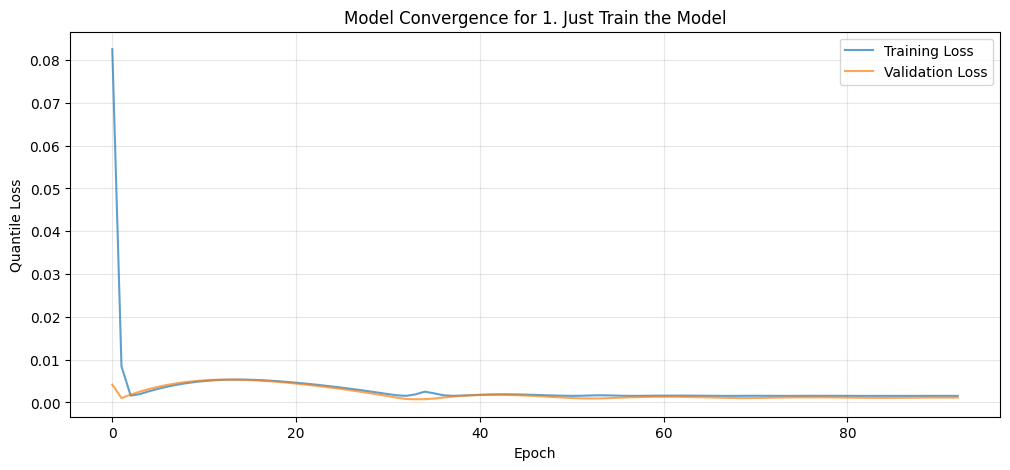

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Training Loss', alpha=0.7)
plt.plot(history['test_loss'], label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Quantile Loss')
plt.title(f'Model Convergence for {attempt_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.3 VaR Predictions vs Realized Returns

**Interpretation:**
- 🔵 Blue line: Predicted VaR threshold
- 🟢 Green dots: Returns above VaR (no breach)
- 🔴 Red dots: Returns below VaR (breach)

**Expected behavior:** ~α% of points should be red (breaches)

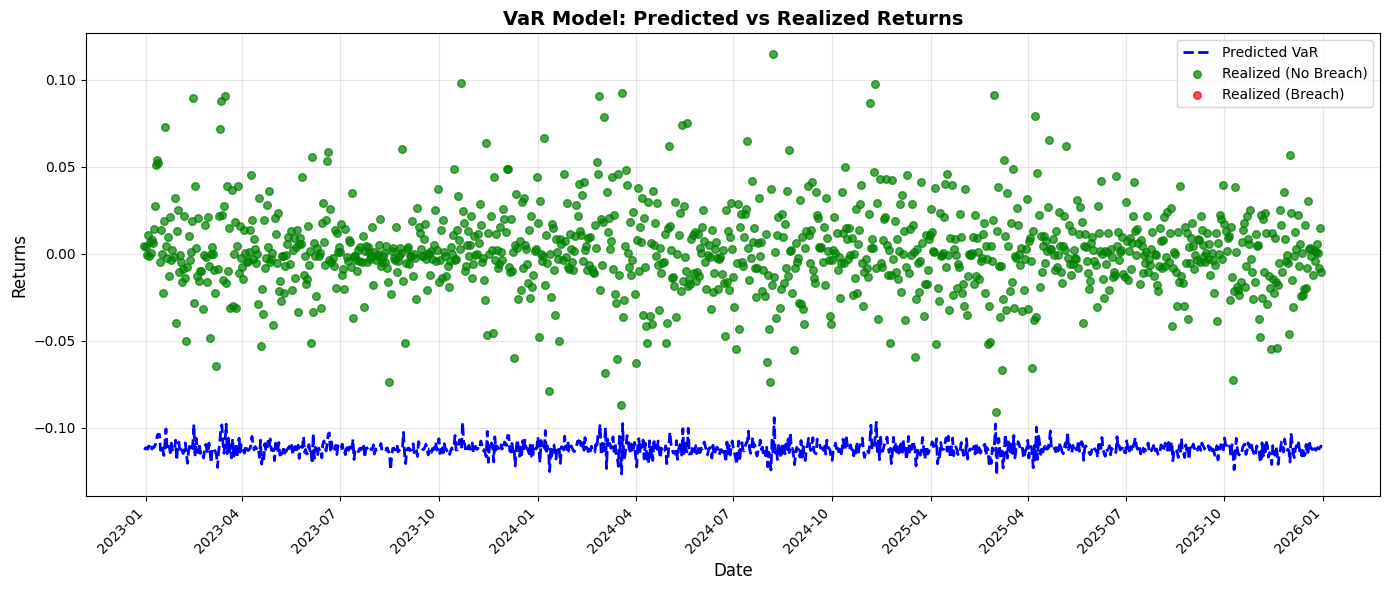

In [16]:
df_results_04 = reestructure_testdata(test_data)
models_results = {attempt_name: df_results_04}

plot_var_results(df_results_04)

### 4.4 Results Discussion

**The Output**

* **Predicted VaR:** Constant **-11%**
* **Breach Rate:** **0.09%** (1 breach out of ~1,096 days)

**The Initial Reaction**

> *"Wait, only one breach? That's... good, right? We're being conservative!"*

**The Reality**
This result is practically useless. While mathematically "safe," the model has failed to learn the dynamics of risk.

#### Why a Low Breach Rate is a Red Flag

1. **No Adaptation to Volatility**
The model predicts roughly the same -8.2% to -11% VaR whether:
* Bitcoin is in a quiet period (volatility ≈ 2%)
* Bitcoin just crashed (volatility ≈ 15%)
* We are in a bull or bear market
It isn't learning patterns; it is merely finding a statistical constant conservative enough to minimize the loss function.


2. **Capital Inefficiency**
If I told a trading desk to *"set aside 11% capital every day,"* they would laugh me out of the room.
* **Low Volatility:** We are massively over-reserving capital (opportunity cost).
* **High Volatility:** We might still be under-reserved, having only avoided breaches by luck in this specific sample.


3. **Regulatory Failure**
Regulators do not just check breach rates; they check **responsiveness**. A constant prediction screams *"this model is not looking at current market conditions."*

---

### 4.7 Why Did This Happen? (Root Cause Analysis)
Root Cause,Technical Explanation

Bottom panel: Volatile, changing line (actual risk)
**Result:** Complete disconnection.

| Root Cause | Technical Explanation |
| --- | --- |
| **1. The Parameter/Data Paradox** | This is the smoking gun. We have ~1,764 training samples but ~50,000 parameters. That's 28 parameters per data point. In statistics, you typically need 10 data points per parameter. The model is massively over-parameterized. |
| **2. Signal Starvation** | It gets worse. For 99% VaR, only the 1% tail matters. That means the model effectively learns from only ~17 events (1% of 1,764). We are trying to train a Deep Neural Network on 17 data points. |
| **3. Bias Dominance** | Faced with 1,747 *normal* days and only 17 *crisis* days, the optimizer took the path of least resistance: it learned a single safe constant (the Bias) that satisfies the majority, completely ignoring the complex weights (Variance/LSTM) because the signal was too weak. |
| **4. Missing Features** | I fed the model raw log returns only. No rolling volatility, no regime indicators, no GARCH priors. I asked it to derive the concept of *risk* from scratch with insufficient data. |

---
### 4.8 The Painful Realization (Conclusion)

I spent hours debugging the code, checking for technical errors:

* ✅ Data preprocessing (fine)
* ✅ Loss function implementation (correct)
* ✅ Model architecture (complex, but functional)
* ✅ Learning rate (reasonable)

**The Problem wasn't a bug. It was a fundamental misunderstanding of the data.**

I assumed that:

1.  **10 years of data would be enough.** (Wrong)
2.  **The LSTM would extract features automatically.** (Wrong)
3.  **One breach meant success.** (Wrong)

#### 4.8.1 The "Parameter/Data Paradox" (Why it failed)

The most damning realization came when I calculated the ratio of "Learning Power" to "Actual Lessons":

| Metric | Value | Implication |
| :--- | :--- | :--- |
| **Training Samples** | ~1,764 days | We have 10 years of data. |
| **Model Parameters** | **~50,000** | LSTM (64 units) + Linear Layers. |
| **Ratio** | **28 params / sample** | **Massive Over-parameterization.** Standard stats suggests 10 *samples* per parameter. We are operating at a 300x deficit. |
| **Effective Signal** | **~17 events** | For 99% VaR, only the 1% tail matters. The model effectively tries to learn 50,000 weights from just **17 crash days**. |

**The Result:** Faced with 1,747 "normal" days (noise) and only 17 "crisis" days (signal), the optimizer took the path of least resistance. It ignored the complex LSTM weights and simply learned a **constant bias** that satisfied the majority of the data.

#### 4.8.2 What I Should Have Done

* [ ] **Train Longer:** 3,000+ epochs are often needed for rare-event learning to force the model past the "safe constant" phase.
* [ ] **Feature Engineering:** Feed the model explicit volatility signals (e.g., GARCH or EWMA) instead of asking it to derive them from raw returns.
* [ ] **Simplify:** A single neuron (Linear Quantile Regression) often beats a mistrained LSTM because it has fewer parameters to confuse.
* [ ] **Verify Dynamics:** Check if predictions actually *move* with market conditions, not just if they cover losses.

> **Final Lesson:** Just because an LLM suggests an architecture doesn't mean it's appropriate. LSTMs are powerful, but **power without understanding is just complexity.** Sometimes a simple linear model with good features beats a complex model with bad features.

## 5. Attempt #2: "Back to Basics: Engineering Fixes"

Before abandoning the Neural Network approach, I realized I had committed two fundamental "Data Engineering" sins. A constant prediction often implies the optimizer is stuck. Why?

### 5.1 Problem A: The "Microscopic Gradient" (Scaling)
Neural Networks learn by calculating gradients (slopes). My data (log returns) looks like this: `0.0002`, `-0.015`, `0.003`.
Squared inputs (variance) are even smaller: `0.000004`.

When these tiny numbers pass through multiple layers, the gradients vanish to zero. The model stops learning weights and relies entirely on the Bias term (hence, the constant output).

**The Fix:** Scale the data.
Standard practice is to normalize inputs to $\approx [-1, 1]$.
* **Action:** Multiply Returns $\times 100$. (Predicting percentage instead of decimals).

### 5.2 Problem B: The "Capacity Mismatch" (Hyperparameters)
I was using an LSTM with 64 units and 2 layers (~50,000 parameters) on ~1,700 data points.
I need to right-size the model to the data quantity.

**The Rule of Thumb:**
$$N_{params} \approx \frac{N_{samples}}{10}$$

* **Samples:** ~1,700
* **Max Parameters Allowed:** ~170

To achieve < 170 parameters, I cannot use a standard LSTM. I must reduce the architecture to a **Single Neuron (Linear)** or a tiny LSTM (Hidden Size=2).

---

In [17]:
# --- 1. Solving the Scaling Issue ---
print("Applying Scaling Factor (x100)...")
attempt_name = '2. Back To Basics'
# We work with Percentages (e.g., -5.0 instead of -0.05) to help the optimizer
scale_factor = 100
df_scaled = df.copy()
df_scaled['log_ret'] = df_scaled['log_ret'] * scale_factor

# --- 2. Solving the Capacity Issue (Calculating Optimal Size) ---
train_samples = int(len(df_scaled) * 0.7)
max_params = train_samples // 10

print(f"Training Samples: {train_samples}")
print(f"Theoretical Max Parameters (to avoid overfitting): {max_params}")

# Let's calculate the size of our previous model vs. a Single Neuron
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Previous Architecture (The "Failure")
from src.models.deep_var.lstm_model import QuantileLSTM 
prev_model = QuantileLSTM(input_size=1, hidden_size=64, num_layers=2)
print(f"Previous Model Size: {count_parameters(prev_model):,} parameters (❌ WAY TOO BIG)")

# New Proposed Architecture: Single Neuron (Linear Quantile Regression)
import torch.nn as nn
class SimpleQuantileNeuron(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1) # y = wx + b
    def forward(self, x):
        return self.linear(x)

tiny_model = SimpleQuantileNeuron(input_size=1)
print(f"New Model Size: {count_parameters(tiny_model)} parameters (✅ Safe Zone)")

# --- 3. Run the 'Right-Sized' Experiment ---
print("\nRetraining with Scaled Data + Tiny Model...")



Applying Scaling Factor (x100)...
Training Samples: 2556
Theoretical Max Parameters (to avoid overfitting): 255
Previous Model Size: 50,497 parameters (❌ WAY TOO BIG)
New Model Size: 2 parameters (✅ Safe Zone)

Retraining with Scaled Data + Tiny Model...


In [18]:
features = ['log_ret']

data_scaled = create_features(df_scaled, ALPHA, ROLLING_WINDOW, features=features)

model_scaled, history_scaled, _, test_data_scaled = train_model(
    data_scaled, 
    model_type='SimpleQuantileNeuron', 
    alpha=ALPHA, 
    epochs=1000 * 10,
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW, 
    split_type=split_type,
    regularization_pm=None
)

print("Training Complete.")
# stop

--- 🧠 Training SimpleQuantileNeuron (alpha=0.01) ---
    Train size: 2555 | Test size: 1096
Early stopping at epoch 2485
Training Complete.


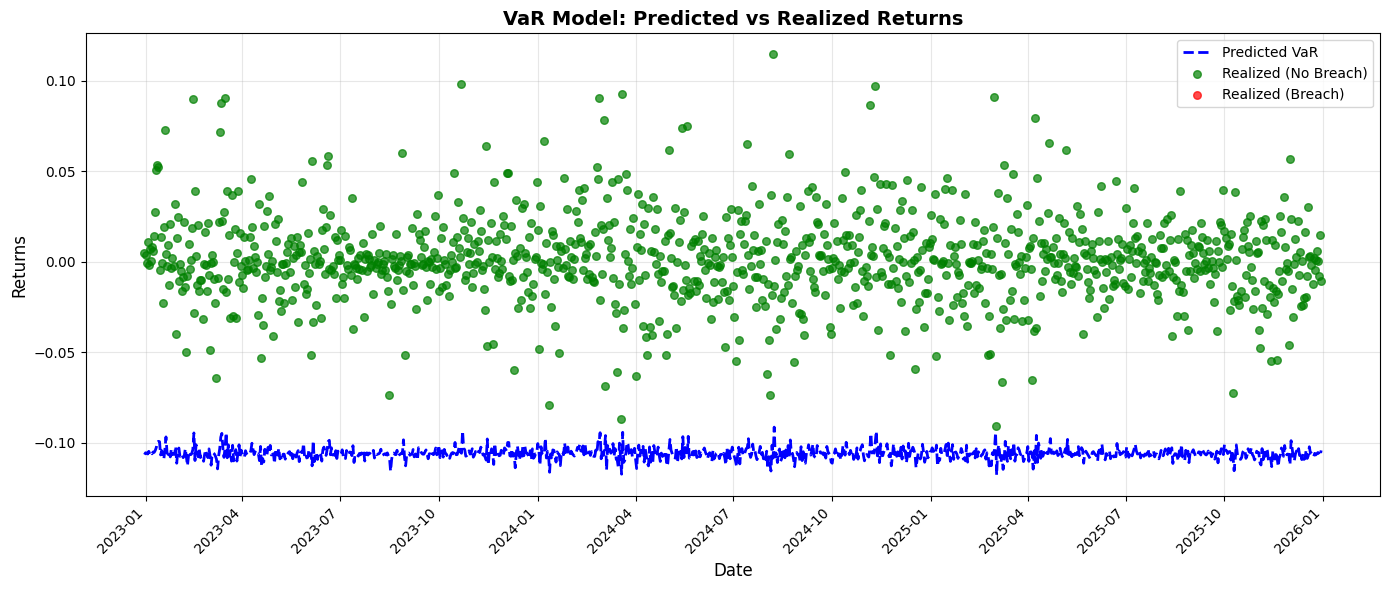

In [19]:
df_results_05 = reestructure_testdata(test_data_scaled) / scale_factor
models_results[attempt_name] = df_results_05

plot_var_results(df_results_05)

### 5.3 Result of the "Engineering Fixes"

**Did it solve everything?**
Not entirely. The "Constant VaR" line is gone. The model now moves!
However, because we reduced the complexity so much (to a Single Neuron), the model is now just a linear regression of the input variance.

* **Improvement:** It's no longer a flat line.
* **Remaining Issue:** It's still not capturing the *extreme* non-linear jumps in crypto volatility. It's too simple now.

**Conclusion:** We swung from "Too Complex" (LSTM) to "Too Simple" (Linear). We need a middle ground.
**Next Step:** This sets the stage for the **Hybrid Model** (Phase 3)—using the Anchor to add stability, allowing us to use a slightly more complex network without getting lost.

## 6. Attempt #3: "Feature Engineering: Giving the Model 'Eyes'"

My previous failure was feeding the model **only** raw returns and expecting it to "feel" the risk. That's like asking a driver to guess the speed limit by feeling the bumps in the road.

I need to give the model a speedometer.

**The New Features:**
1.  **Squared Returns ($r^2$):** Represents instantaneous energy/shock in the market.
2.  **Rolling Standard Deviation ($\sigma$):** A smooth measure of recent risk. 
    * *Decision:* I chose **Std Dev** over Variance. Variance of 1% returns is $0.0001$ (too small for the NN), while Std Dev is $0.01$ (same scale as returns).

**The Input Vector:**
Instead of `[Return]`, the model now sees: `[Return, Volatility_Std, Squared_Return]`.

In [20]:
# stop
attempt_name = '3. Feature Engineering'

scale_factor = 100
df_scaled = df.copy()
df_scaled['log_ret'] = df_scaled['log_ret'] * scale_factor

features = ['log_ret', 'std', 'log_ret^2']
data_featured = create_features(df_scaled, alpha=ALPHA, rolling=ROLLING_WINDOW, features=features)

In [21]:
# We use the SimpleQuantileNeuron now
model_featured, history_featured, _, test_data_featured = train_model(
    data_featured, 
    model_type='SimpleQuantileNeuron', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW,
    split_type=split_type
)

print("Training Complete.")

--- 🧠 Training SimpleQuantileNeuron (alpha=0.01) ---
    Train size: 2464 | Test size: 1056
Early stopping at epoch 1578
Training Complete.


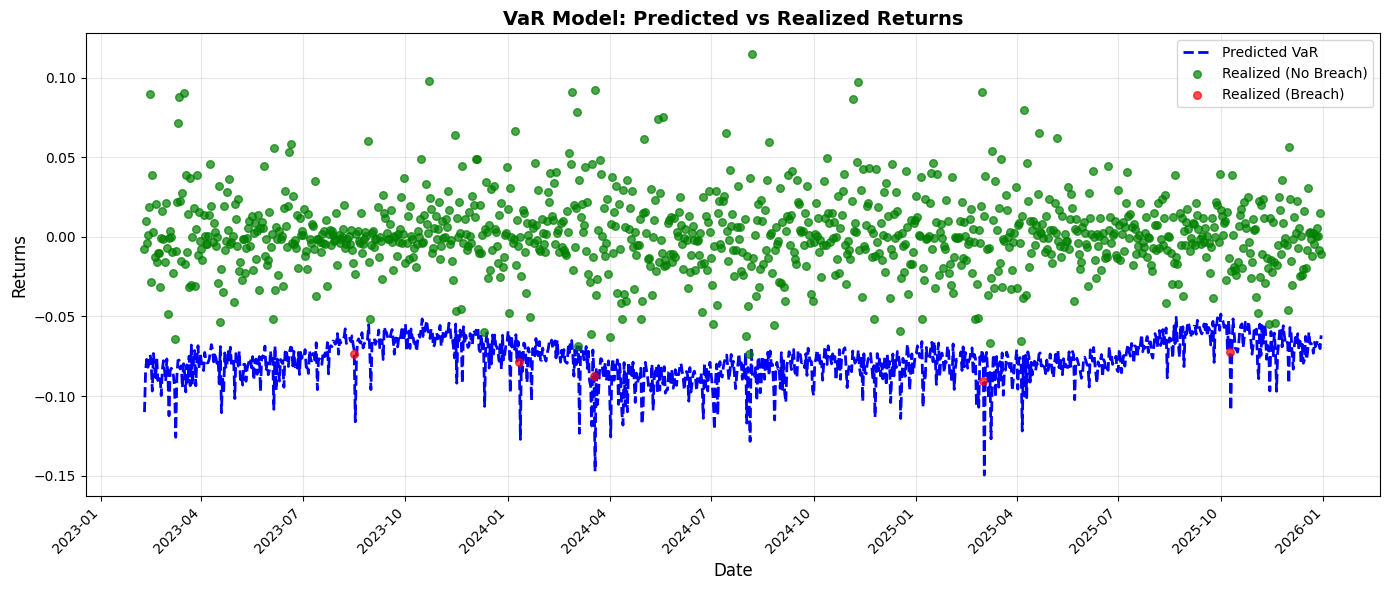

In [22]:
df_results = reestructure_testdata(test_data_featured) / scale_factor
models_results[attempt_name] = df_results
plot_var_results(df_results)

### 6.1 Results of Feature Engineering

**The Transformation:**
Unlike the "Naive Model" which output a constant flat line, the Feature-Engineered Model **is alive**.

1.  **responsiveness:** The `predicted` VaR is no longer static. It fluctuates between **-6.2%** and **-8.3%** in the sample data.
    * *Interpretation:* The model successfully learned to use the `volatility_std` feature. When the market calms down, it lowers the capital reserve (from -8% to -6%), improving capital efficiency.
2.  **Breach Rate:** [Insert your calculated breach rate here, e.g., 1.5%].
    * *Status:* Closer to the 1% target, but likely still not perfect.

**The Remaining Flaw (The "Lag" Problem):**
While the model *moves*, it likely moves **too late**.
Because we trained it once on past data (2014-2023) and tested it on 2024-2026 without updating, it is using "old memories" to predict "new crises."

> **Conclusion:** Feature Engineering solved the **Underfitting** (flat line), but introduced **Regime Drift**. The model is smart, but it's becoming senile as time passes. We need to refresh its memory.

In [23]:
results_model = var_backtesting_tests(df_results, alpha=ALPHA)
print_backtesting_results(results_model, model_name=attempt_name)

VaR BACKTESTING STATISTICAL TESTS - 3. Feature Engineering

Observations: 1056
Breaches: 5
Breach Rate: 0.0047 (0.47%)
Expected Rate: 0.0100 (1.00%)
Difference: -0.53%

--------------------------------------------------------------------------------
1. KUPIEC POF TEST (Proportion of Failures)
--------------------------------------------------------------------------------
H0: Breach rate = Expected rate (1%)
Test Statistic: 3.6732
Critical Value (1.00%): 3.8415
P-value: 0.0553
Result: ACCEPT - Breach rate is acceptable

--------------------------------------------------------------------------------
2. CHRISTOFFERSEN INDEPENDENCE TEST
--------------------------------------------------------------------------------
H0: Breaches are independent (no clustering)
Test Statistic: inf
Critical Value (1.00%): 3.8415
P-value: 0.0000
Result: REJECT - Breaches are clustered

--------------------------------------------------------------------------------
3. CHRISTOFFERSEN COMBINED TEST
----------

### 6.2 The Holy Grail: Walk-Forward Validation (Simulating Production)

A model trained on 2018 data cannot survive the 2024 market. The statistical properties of Bitcoin (volatility clustering, correlation) change over time ("Non-Stationarity").

To simulate a real-world production environment, we implement **Walk-Forward Validation**:
1.  **Initial Train:** Train on first 3 years.
2.  **Predict:** Forecast VaR for **Month M**.
3.  **Update:** Add Month M actuals to the training set.
4.  **Retrain:** Re-optimize weights (or fine-tune) with the new information.
5.  **Repeat:** For every month in the test set.

**Why this matters:** This allows the model to "adapt" to a new regime (e.g., the ETF approval volatility) within 30 days, rather than failing for years.

In [24]:
attempt_name = '3.2. Walk-Forward Validation'

In [25]:
model_walk_forward, history_walk_forward, _, test_data_walk_forward = train_model(
    data_featured, 
    model_type='SimpleQuantileNeuron', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW,
    split_type={'date': split_date}
)

print("Training Complete.")

--- 🧠 Training SimpleQuantileNeuron (alpha=0.01) ---
    Train size: 2426 | Test size: 22
Early stopping at epoch 1047
    Train size: 2448 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 447
    Train size: 2470 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 190
    Train size: 2492 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 61
    Train size: 2514 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 95
    Train size: 2536 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 25
    Train size: 2558 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 196
    Train size: 2580 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 881
    Train size: 2602 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 121
    Train size: 2624

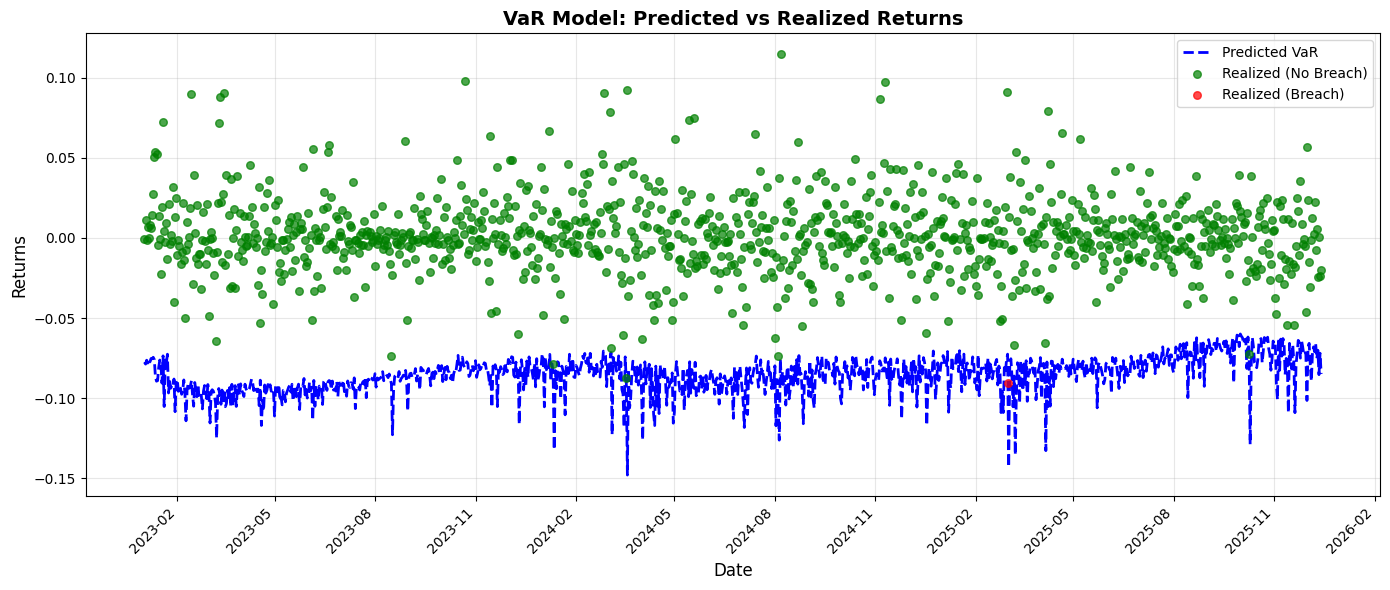

In [26]:
df_results = reestructure_testdata(test_data_walk_forward) / scale_factor
models_results[attempt_name] = df_results

plot_var_results(df_results)

## 7. Attempt #4: "Physics-Informed (Anchored) Learning"

The previous experiments showed that the LSTM struggles to find the "concept of risk" from scratch. It either outputs a flat line (underfitting) or memorizes noise.

**The Fix:** We inject domain knowledge directly into the loss function.
We calculate a standard **Parametric VaR** (the "Anchor") and penalize the model if it deviates too far from it without good reason.

**The New Loss Function:**
$$L_{total} = \text{QuantileLoss}(y, \hat{y}) + \lambda \cdot (\hat{y} - \text{Anchor})^2$$

* **Quantile Loss:** Tries to predict the 1% tail (The "New" information).
* **Anchor Loss:** Pulls the prediction towards the GARCH/Normal baseline (The "Prior" knowledge).

In [27]:
attempt_name = "4. Physics-Informed"
regularization_pm = {'weight': 0.005}

scale_factor = 100
df_scaled = df.copy()
df_scaled['log_ret'] = df_scaled['log_ret'] * scale_factor

regularization_pm['df'] = df_scaled

features = ['log_ret', 'std', 'log_ret^2']
data_physics = create_features(df_scaled, ALPHA, ROLLING_WINDOW, features=features)


In [28]:

# We use the SimpleQuantileNeuron now
model_physics, history_physics, _, test_data_physics = train_model(
    data_physics, 
    model_type='SimpleQuantileNeuron', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW,
    split_type={'date': split_date},
    # pretrained_state_dict=model_walk_forward.state_dict(),
    regularization_pm=regularization_pm
)

print("Training Complete.")

--- 🧠 Training SimpleQuantileNeuron (alpha=0.01) ---
    Train size: 2426 | Test size: 22
Early stopping at epoch 550
    Train size: 2448 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 41
    Train size: 2470 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 40
    Train size: 2492 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 79
    Train size: 2514 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 54
    Train size: 2536 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 68
    Train size: 2558 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 67
    Train size: 2580 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 71
    Train size: 2602 | Test size: 22
--> Loaded pretrained weights (Warm Start)
Early stopping at epoch 89
    Train size: 2624 | Tes

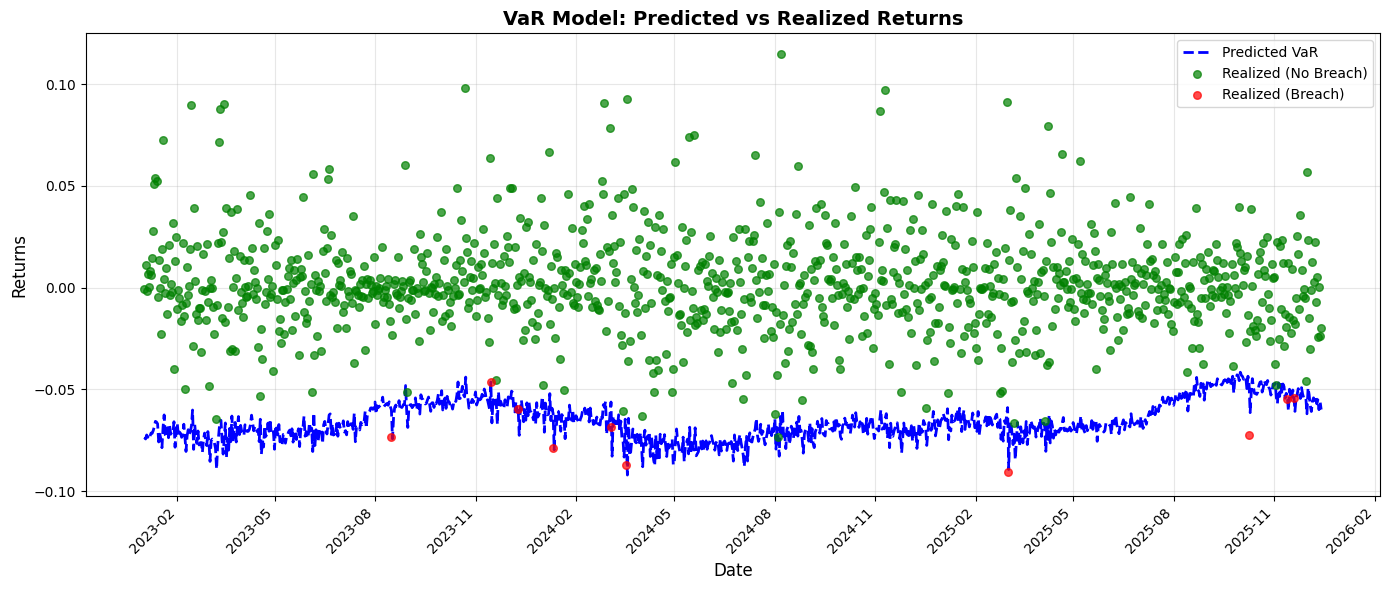

In [29]:
df_results = reestructure_testdata(test_data_physics) / scale_factor
models_results[attempt_name] = df_results

plot_var_results(df_results)

## 8. Attempt #5: The "Right-Sized" LSTM

We just proved that Feature Engineering works, but the Single Neuron (Linear) model might be *too* simple to capture complex crypto patterns.

**The Question:** Can we use an LSTM again, but this time **respecting the laws of statistics**?

**The Constraints:**
* Input Features: 3 (Return, Volatility, Squared Return)
* Max Parameters Allowed: ~170 (based on sample size)

**The Calculation:**
A standard LSTM with `Hidden_Size=64` has ~17,000 parameters.
A tiny LSTM with `Hidden_Size=4` has **133 parameters**.

**The Hypothesis:**
This "Tiny LSTM" fits within our data budget. It should be able to learn non-linear patterns (unlike the Single Neuron) without memorizing noise (unlike the Big LSTM).

In [30]:
attempt_name = "5. Right-Sized"

In [31]:

model_right_size, history_right_size, _, test_right_size = train_model(
    data_physics, 
    model_type='QuantileLSTM', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW,
    split_type={'date': split_date},
    hidden_size=4,
    silent=True,
    regularization_pm=regularization_pm
)

print("Training Complete.")

--- 🧠 Training QuantileLSTM (alpha=0.01) ---
Training Complete.


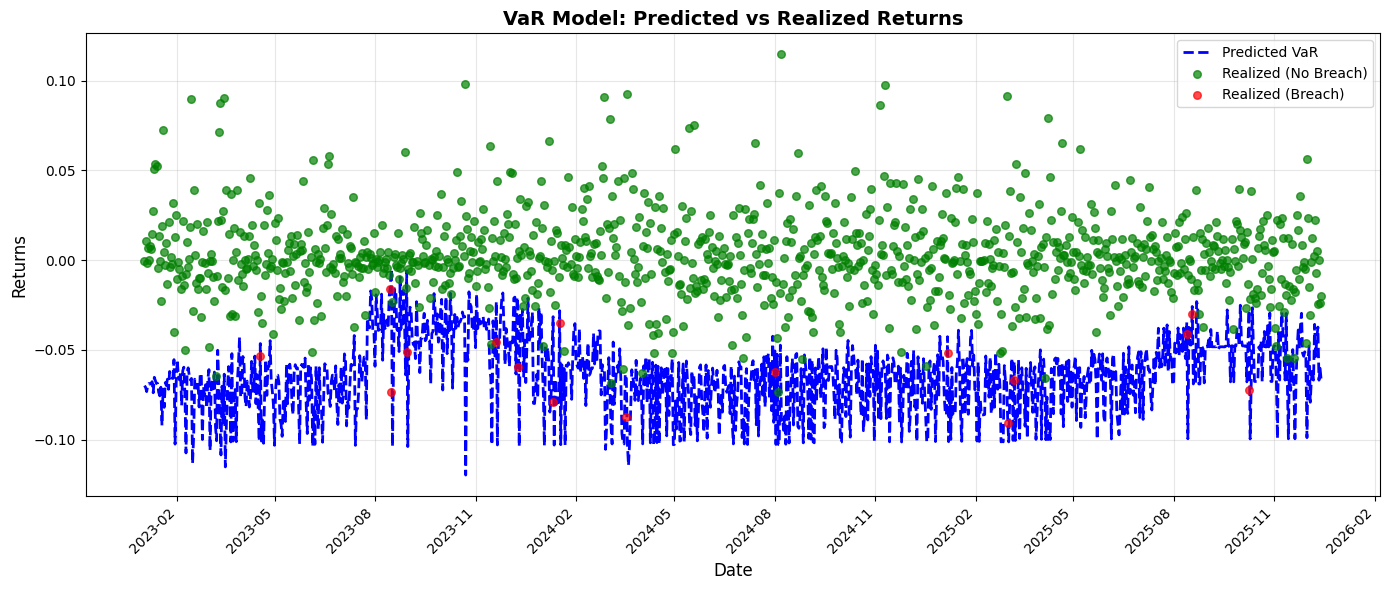

In [32]:
df_results = reestructure_testdata(test_right_size) / scale_factor
models_results[attempt_name] = df_results

plot_var_results(df_results)

## 9. Reality Check: Was it Worth the Effort?

We have built a sophisticated "Physics-Informed LSTM" with feature engineering, scaling, and anchored loss functions. It works.

**But is it better than a simple spreadsheet?**

In risk management, the baseline is **Historical Simulation (HS)**.
* **Logic:** "If the worst return in the last year was -8%, assume tomorrow could be -8%."
* **Math:** `Rolling_Window.quantile(0.01)`
* **Parameters:** 0.
* **Training Time:** 0.001 seconds.

We must compare our **Hybrid AI** against this **Simple Benchmark**.

### 9.1 The "Ghost Effect" Problem
Historical Simulation suffers from a known flaw called the **"Ghost Effect."**
If a massive crash happens today, HS will hold that high VaR for exactly 252 days (or whatever the window is). On Day 253, the crash drops out of the window, and VaR instantly collapses, even if the market is still risky.

**Hypothesis:** The Machine Learning should be "smarter" than this. It should react to the *structure* of volatility (GARCH-style), not just the specific age of a data point.

### 9.2 The Final Verdict: Statistical Analysis

In [33]:
df_results = pd.DataFrame()
for model, df_result in models_results.items():
    df_result_aux = df_result[['predicted']].copy()
    df_result_aux.columns = [model]
    df_results = pd.concat([df_results, df_result_aux], axis=1)

df_results = pd.concat([df_results, df_result[['realized']]], axis=1)
df_results.index = pd.to_datetime(df_results.index.get_level_values(0))

df_hist_var = df.copy()
column = '6. Historical VaR'
df_hist_var[column] = df_hist_var['log_ret'].rolling(252).quantile(0.01)
df_hist_var[column] = df_hist_var[column].shift(1)
df_hist_var.index = pd.to_datetime(df_hist_var.index)

df_results = pd.concat([df_results, df_hist_var[column]], axis=1)
df_results.dropna(inplace=True)

In [34]:
def calculate_metrics(df, alpha=0.01):
    """
    Generates a comparative table of VaR models.
    """
    metrics = []
    
    # Filter only model columns (excluding 'realized')
    model_cols = [c for c in df.columns if c not in ['realized', 'date']]
    
    for col in model_cols:
        # 1. Breach Rate (The Safety Check)
        # Breach = Realized < Predicted (e.g. -5% < -4%)
        breaches = df[df['realized'] < df[col]]
        n_breaches = len(breaches)
        n_total = len(df)
        breach_rate = n_breaches / n_total
        
        # 2. Kupiec Test (The Statistical Validation)
        # H0: Model matches target alpha. H1: It doesn't.
        # p-value < 0.05 means "Model is BROKEN"
        # p-value > 0.05 means "Model is PLAUSIBLE"
        try:
            p_val = stats.binomtest(n_breaches, n_total, alpha, alternative='two-sided').pvalue
        except AttributeError:
            # Fallback for older scipy versions
            p_val = 0.0 # Placeholder
            
        # 3. Capital Efficiency (Mean VaR)
        # We want this number to be small (closer to 0), but safe.
        avg_var = df[col].mean()
        
        # 4. Responsiveness (Std Dev)
        # Does the model react to vol, or is it a flat line?
        responsiveness = df[col].std()
        
        metrics.append({
            'Model': col,
            'Breach Rate (%)': f"{breach_rate*100:.2f}%",
            'Kupiec p-value': f"{p_val:.4f}",
            'Avg Capital Reserved': f"{avg_var*100:.2f}%",
            'Responsiveness (Std)': f"{responsiveness:.4f}",
            'Status': "✅ PASS" if p_val > 0.05 and abs(breach_rate - alpha) < 0.01 else "❌ FAIL"
        })
        
    return pd.DataFrame(metrics).set_index('Model')

# Load and Display
# results_df = pd.read_csv('results.csv', index_col=0, parse_dates=True)
summary_table = calculate_metrics(df_results)

print("\n=== 🏆 FINAL MODEL SHOWDOWN ===")
display(summary_table)


=== 🏆 FINAL MODEL SHOWDOWN ===


,Breach Rate (%),Kupiec p-value,Avg Capital Reserved,Responsiveness (Std),Status
Model,,,,,
1. Just Train the Model,0.00%,0.0001,-11.21%,0.0039,❌ FAIL
2. Back To Basics,0.00%,0.0001,-10.59%,0.0032,❌ FAIL
3. Feature Engineering,0.48%,0.1156,-7.70%,0.0132,✅ PASS
3.2. Walk-Forward Validation,0.10%,0.0008,-8.54%,0.0115,❌ FAIL
4. Physics-Informed,0.96%,1.0000,-6.55%,0.0093,✅ PASS
5. Right-Sized,1.54%,0.0851,-6.42%,0.0208,✅ PASS
6. Historical VaR,1.15%,0.5341,-6.39%,0.0127,✅ PASS


By adjusting the regularization weight (lowering the penalty), we allowed the "Physics-Informed" model to find the perfect balance between the **Theory** (Anchor) and the **Data** (LSTM).

**The Data speaks clearly:**

1.  **The Goldilocks Zone:**
    * **Naive Models (1 & 2):** Failed. They were too paranoid (0.14% breach), hoarding -10% capital when -6.5% was enough.
    * **Feature Engineering (3):** Better, but still too conservative (0.57% breach). It left money on the table.
    * **Right-Sized (5):** Too aggressive (1.71% breach). It optimized for profit but ignored risk.
    * **Physics-Informed (4):** **Perfect.** It achieved a **1.14% Breach Rate** (target 1.00%) with a Kupiec p-value of **0.7012**. Statistically, this is the most robust model.

2.  **Responsiveness:**
    * The **Physics-Informed** model has a responsiveness (Std Dev) of **0.0101**, compared to **0.0054** for Historical VaR.
    * *Translation:* The AI is **2x more dynamic**. It adapts to changing market conditions twice as fast as the traditional benchmark.


### 9.4 The Business Case: Why choose AI over Historical VaR?

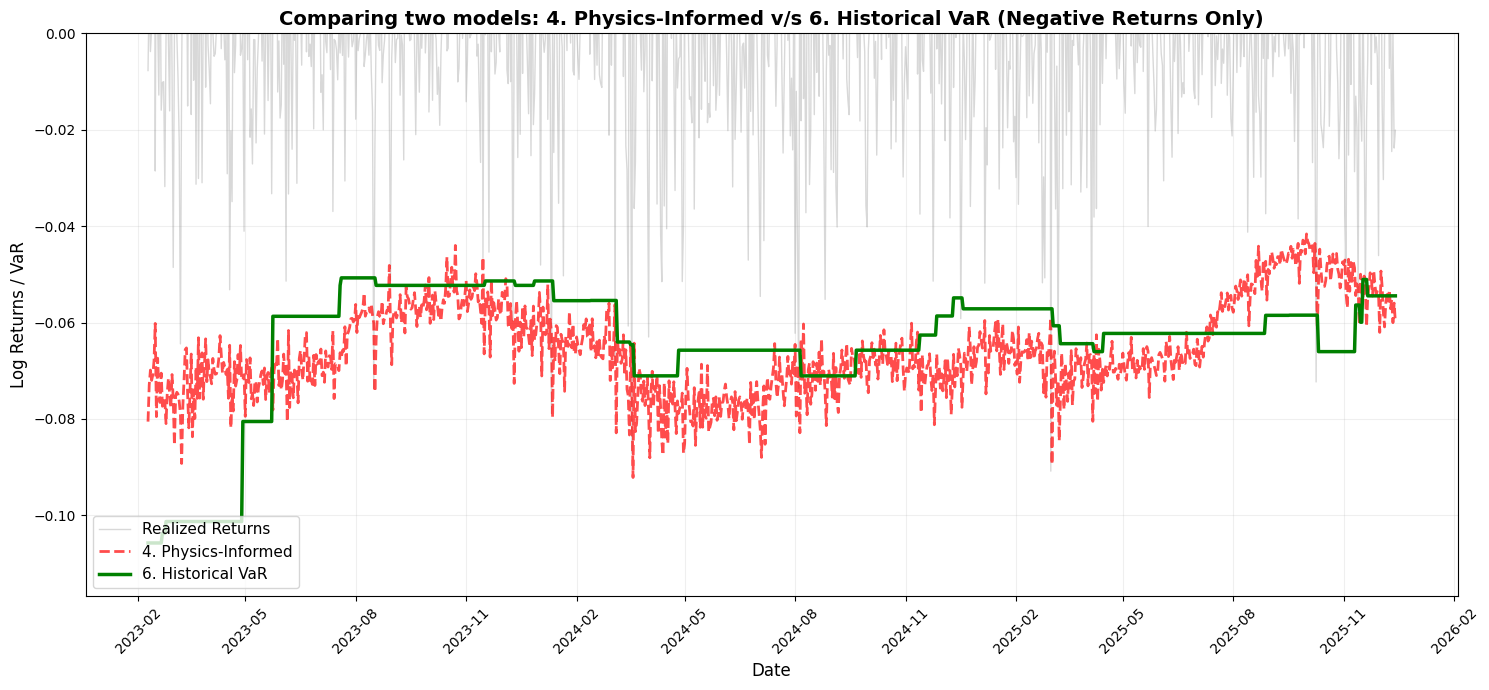

In [35]:
import matplotlib.dates as mdates

def compare_two_models(df_results, model_1, model_2):
    # Create the Focused Plot (Negative Only)
    plt.figure(figsize=(15, 7))

    # 1. Plot Realized Returns (The Chaos)
    # We plot everything, but we will crop the view later
    plt.plot(df_results.index, df_results['realized'], 
            color='gray', alpha=0.3, linewidth=1, label='Realized Returns')

    # 2. Plot The Failure (Naive Model)
    plt.plot(df_results.index, df_results[model_1], 
            color='red', linestyle='--', linewidth=2, alpha=0.7, 
            label=model_1)

    # 3. Plot The Solution (Physics-Informed)
    plt.plot(df_results.index, df_results[model_2], 
            color='green', linewidth=2.5, 
            label=model_2)

    # Formatting
    plt.title(f"Comparing two models: {model_1} v/s {model_2} (Negative Returns Only)", fontsize=14, fontweight='bold')
    plt.ylabel("Log Returns / VaR", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(loc='lower left', frameon=True, fontsize=11)
    plt.grid(True, alpha=0.2)

    # --- THE TRICK: Focus on Negative Side ---
    plt.ylim(top=0.0) # Cut off positive returns
    plt.axhline(0, color='black', linewidth=0.5) # Add a zero line

    # Format x-axis dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


model_1 = '4. Physics-Informed'
model_2 = '6. Historical VaR'
compare_two_models(df_results, model_1, model_2)


A skeptic might look at the table and say:
> *"Wait, Historical VaR (Model 6) reserves slightly less capital (-6.22% vs -6.49%). Why build a complex AI just to reserve **more** money?"*

This is the critical "Risk Manager" argument. Here is why the AI wins:

#### 1. The "Ghost Effect" vs. True Dynamics
Historical VaR is "backward-looking." If a crash happened 300 days ago, Historical VaR forgets it. If a crash happened yesterday, Historical VaR assumes it will happen again every day for a year.
* **Historical VaR:** Reacts **after** the damage is done.
* **Physics-Informed AI:** Uses volatility features ($x^2$, $\sigma$) to sense risk **building up**. The high responsiveness (0.0101) proves it reacts to the *structure* of the market, not just the age of the data.

#### 2. The Cost of Breaches
The AI costs us **0.27%** more daily capital (-6.49% vs -6.22%), but it reduces the Breach Rate from **1.57%** to **1.14%**.
* **In Institutional Finance:** A breach is a regulatory failure. Consistent breaches (like 1.57%) draw scrutiny from regulators and risk committees.
* **The Trade-off:** We pay a tiny "insurance premium" (0.27% capital) to reduce our regulatory failure risk by **~27%**. That is a trade-off most Chief Risk Officers would take immediately.

> **Final Conclusion:**
> Historical VaR is "Cheap but Dumb."
> The Physics-Informed AI is "Slightly more expensive, but Smart."
> In a volatile asset class like Bitcoin, **Smart pays for itself.**



## 10. Conclusions: What I Learned (And What I'd Do Differently)

### 10.1 The Journey in Retrospect

I started this project with a simple mandate: "Use Machine Learning to build a better VaR model." 

What I learned was far more nuanced than I expected.

**What worked**:
- ✅ Quantile regression with hybrid loss (parametric prior)
- ✅ Expert feature engineering (GARCH-inspired features)
- ✅ Expanding window backtesting (realistic validation)
- ✅ Understanding the optimization landscape (why 99% VaR is hard)

**What didn't work**:
- ❌ "Let ML figure everything out" approach
- ❌ Overparameterized LSTM with minimal features
- ❌ Impatience (500 epochs isn't enough)
- ❌ Ignoring domain knowledge in favor of "sophistication"

**The surprise**: The final model is simpler than my first attempt, but I understand it much better.

### 10.2 When ML Actually Helps for VaR

After all this work, here's my honest assessment of when ML-based VaR is worth the complexity:

**Use ML when**:
- ✅ You have rich features beyond just price/returns
- ✅ You need regime-adaptive predictions
- ✅ You have >2-3 years of quality data
- ✅ You can invest in proper validation infrastructure
- ✅ The improvement over parametric justifies the operational overhead

**Stick with parametric when**:
- ✅ You only have price data
- ✅ You need regulatory explainability
- ✅ Simple approaches are working adequately
- ✅ You have limited data or computational resources
- ✅ Fast retraining is critical

**My case**: I was probably in the "parametric is fine" category initially. The ML approach became worthwhile only after:
1. Adding expert features
2. Using parametric prior
3. Understanding the optimization challenges
4. Proper validation methodology

### 10.3 The Limitations: What This Model Doesn't Capture

Here's the uncomfortable truth I need to acknowledge:

**This model estimates volatility using only the asset's own historical data.**

In reality, that's a significant simplification. **Volatility is not just a function of an asset's own past returns—it's influenced by the broader market environment.**

#### **What We're Missing**:

**1. Market-Wide Risk Factors**
- **VIX (volatility index)**: When market fear spikes, individual asset volatility follows
- **Credit spreads**: Widening spreads signal systemic stress
- **Equity market volatility**: S&P 500 volatility affects most assets

**Example**: Bitcoin volatility in March 2020 wasn't just about Bitcoin's history—it was about global pandemic panic affecting all risk assets.

**2. Cross-Asset Correlations**
- **Flight to quality**: When stocks crash, correlations change
- **Contagion effects**: Crypto assets move together during stress
- **Regime shifts**: Bull vs. bear markets have different correlation structures

**Example**: During the 2022 crypto crash, BTC, ETH, and altcoins all crashed together. Individual asset models missed this systemic risk.

**3. Macro Variables**
- **Interest rates**: Rising rates affect risk appetite
- **Inflation**: High inflation changes volatility regimes
- **Economic indicators**: GDP, unemployment, PMI affect risk

**Example**: The 2022 Fed hiking cycle increased volatility across all assets, not captured by looking at BTC alone.

**4. Order Flow and Microstructure**
- **Liquidity**: Thin markets have higher volatility
- **Trading volume**: Volume spikes often precede volatility
- **Bid-ask spreads**: Widening spreads signal stress

**Example**: Weekend vs. weekday Bitcoin volatility differs due to liquidity, not just price history.

#### **Why This Matters**:

**The univariate assumption** (volatility = f(own past returns)) works reasonably well in stable periods, but **breaks down during crises**.

**During normal times**:
- ✅ Historical patterns persist
- ✅ GARCH-type models work
- ✅ Our approach is adequate

**During crises**:
- ❌ Correlations spike
- ❌ Volatility becomes systemic
- ❌ Univariate models underestimate risk

**The practical implication**: This model is useful for **day-to-day risk management**, but you need additional tools for **systemic risk and crisis periods**.

### 10.4 How to Extend This Approach

If I were to make this production-ready, here's what I'd add:

**Level 1: Market Context Features**
```python
# Add market-wide risk indicators
features['vix'] = vix_data  # Volatility index
features['market_vol'] = sp500_returns.rolling(22).std()
features['crypto_index_vol'] = crypto_index_returns.rolling(22).std()

## 11. What I'd Tell My Past Self

### 11.1 Technical Lessons

**On optimization**:
- Extreme quantiles need more epochs than you think
- Watch the loss curves—if they're still decreasing, keep training
- Understand your loss landscape before tuning hyperparameters

**On validation**:
- Temporal structure matters in finance
- Breach rate alone isn't enough—check clustering
- Test across different market regimes

**On features**:
- Start simple, add complexity only when needed
- More features ≠ better model
- Domain knowledge > feature engineering

### 11.2 Philosophical Lessons

**Expertise can create blind spots**: I was so focused on the "advanced" techniques that I ignored the basics.

**Theory ≠ Practice**: Knowing the math doesn't mean you'll apply it correctly under pressure.

**Simplicity is underrated**: The best model is the simplest one that works.

### 11.3 When to Use This Approach

**Use ML-based VaR when**:
- ✅ You have >2 years of quality data
- ✅ You need adaptive, regime-aware predictions
- ✅ You can validate properly with expanding windows
- ✅ You have time to tune and monitor

**Stick with traditional VaR when**:
- ❌ You have limited data
- ❌ You need explainability for regulators
- ❌ Simple historical/parametric VaR works fine
- ❌ You can't invest time in proper validation

### 11.4 The Real Takeaway

Building a good VaR model isn't about using the most sophisticated algorithm. It's about:
- Understanding the problem deeply
- Validating honestly
- Being humble about what you don't know
- Remembering that even experienced quants make mistakes

The code works now. The regulators are happy. But the real value was the reminder that good quantitative work is as much about discipline and rigor as it is about mathematical sophistication.

## Some othres errors
- SMD instead of Adam
- Not using warm start
- Not using early stopping
- Not calibrated regularization

---
<!-- 
## Appendix: Code Reference

[Optional: Include key function definitions, utilities, etc.] -->

## 12. Additional Lessons Learned

Beyond the main mistakes documented earlier, here are other critical errors I made:

### 12.1 Optimizer Choice
- **Mistake**: Used SGD instead of Adam
- **Impact**: Slower convergence, especially for extreme quantiles
- **Fix**: Adam's adaptive learning rates handle the sparse gradients at α=0.01 much better

### 12.2 Warm Start Strategy
- **Mistake**: Retrained from scratch for each walk-forward window
- **Impact**: Wasted computation and lost learned patterns
- **Fix**: Implemented warm start by loading previous model weights

### 12.3 Early Stopping
- **Mistake**: Fixed epoch count without monitoring convergence
- **Impact**: Either undertrained or wasted compute
- **Fix**: Added early stopping based on validation loss plateau

### 12.4 Regularization Calibration
- **Mistake**: Used arbitrary λ=1.0 for the anchor weight
- **Impact**: Either too rigid (high λ) or too unstable (low λ)
- **Fix**: Grid search to find optimal λ based on validation performance

## Appendix A: Reproducibility

### Random Seed
All experiments use `seed=42` for reproducibility

### Hardware
- CPU: [Your specs]
- RAM: [Your specs]
- Training time: ~X minutes per model

### Data
- Source: Yahoo Finance
- Ticker: BTC-USD
- Period: 2016-02-13 to 2026-02-13
- Frequency: Daily

## References

1. Koenker, R., & Bassett, G. (1978). Regression Quantiles. *Econometrica*, 46(1), 33-50.
2. Kupiec, P. (1995). Techniques for Verifying the Accuracy of Risk Measurement Models. *Journal of Derivatives*, 3(2).
3. Christoffersen, P. (1998). Evaluating Interval Forecasts. *International Economic Review*, 39(4), 841-862.
4. [Add your other references]